***
## Table of Contents
<br>
  <br>
    <ol>
        <h2><a href='#1' style="text-decoration : none; color : #000000;">1. Initial Models</a></h2>
        <ul>
            <a href='#1.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#1.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br> 

<ol>
        <h2><a href='#2' style="text-decoration : none; color : #000000;">2. Oversampling </a></h2>
        <ul>
            <a href='#2.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#2.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
 <ol>
        <h2><a href='#3' style="text-decoration : none; color : #000000;">3. Undersampling</a></h2>
        <ul>
            <a href='#3.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#3.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
 <ol>
        <h2><a href='#4' style="text-decoration : none; color : #000000;">4.Feature Transformation with feature selection</a></h2>
        <ul>
            <a href='#4.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#4.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
     
 <ol>
        <h2><a href='#5' style="text-decoration : none; color : #000000;">5.Feature Transformation with PCA</a></h2>
        <ul>
            <a href='#5.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#5.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>

In [1]:
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from IPython.display import display,clear_output,HTML
import warnings
warnings.filterwarnings("ignore")

import keras
from keras.layers import Dense,Dropout
from keras.models import Sequential
warnings.simplefilter("ignore", DeprecationWarning)
import researchpy as rp

%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows',305)

from sklearn.feature_selection import SelectKBest,chi2,RFE,RFECV,f_regression,SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier,BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split,cross_val_score

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn import metrics



from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score,auc,roc_curve,recall_score,precision_score,matthews_corrcoef

from pandas_ml import ConfusionMatrix


from imblearn.over_sampling import SMOTE

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

import featuretools as ft

from scipy import stats
import re

Using TensorFlow backend.


In [2]:
### Function to plot Feature Importance
def feat_impt_plot(feat_impt,y_labels,width_s=1000,height_s=1000):
    
    m=pd.DataFrame(y_labels,feat_impt).reset_index()
    m.columns=['Feature_Importance','Features']
    m.sort_values(by='Feature_Importance',inplace=True,ascending=False)
    m['Features']=m['Features'].str.replace("dom_function_","")
    m['Features']=m['Features'].str.replace("js_function_","")
    m['Features']=m['Features'].apply(lambda x: str(x).lstrip('.'))
    m['Features']=m['Features'].str.replace("(","")
    
    data = [go.Bar(x=m.Feature_Importance.values,y=m.Features.values,text=np.round(m.Feature_Importance,4),
            textposition = 'outside',
            marker=dict(
                color='rgb(158,202,225)',
                line=dict(
                    color='rgb(8,48,107)',
                    width=1.5),
            ),
            opacity=0.6,
            orientation='h'
        )]
    layout = go.Layout(autosize=False,
    width=width_s,
    height=height_s,
    xaxis=dict(title='Feature Importances',
        tickfont=dict(
            size=12,
            color='black'
        )),
    yaxis=dict(automargin=True))
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)

In [3]:
def uni_value(data):
    lst=[]
    for col in data.columns[:]:
        lst.append([col,dict(data[col].value_counts()),data[col].value_counts().values[0]>=len(data)*0.95])
    col_values=pd.DataFrame(lst,columns=['Feature','Value_Counts','95_%_same_values'])
    col_values.set_index('Feature',drop=True,inplace=True)
    del lst
    return col_values

    
def check_cat(data):
    cat_var=[]
    num_var=[]
    for col in data.columns:
        if col!='Target':
            if len(data[col].value_counts())==2:
                cat_var.append(col)
            else:
                num_var.append(col)
    return cat_var,num_var


def num_stats(data,columns):
    lst=[]
    c=0
    for col in columns:
        corr=stats.pointbiserialr(data[col],data.Target)[0]
        corr_p=stats.pointbiserialr(data[col],data.Target)[1]
        ttest=stats.ttest_ind(data[data.Target==1][col], data[data.Target==0][col], equal_var=False)[0]
        ttest_p=stats.ttest_ind(data[data.Target==1][col], data[data.Target==0][col], equal_var=False)[1]
        lst.append((corr,corr_p,ttest,ttest_p,col))
    stats_data=pd.DataFrame(lst,columns=['Pt. Biserial Corr','Pt. Biserial Corr p-val','ttest','ttest p-val','Feature'])
    stats_data.set_index('Feature',drop=True,inplace=True)
    stats_data.sort_values(by='ttest',inplace=True)
    del lst
    return stats_data


### Generate statistics for categorical data
def cat_stats(data,columns):
    lst=[]
    c=0
    for col in columns:
        if col!='Target':
            table, results = rp.crosstab(data['Target'], data[col], prop= 'col', test= 'chi-square')
            x=results['results'].values.tolist()
            x.append(col)
            lst.append(x)
    chi_df=pd.DataFrame(lst,columns=['Pearson Chi-square','p-value','Cramers V','Feature'])
    chi_df.set_index('Feature',drop=True,inplace=True)
    chi_df.sort_values(by='Cramers V',ascending=False,inplace=True)
    del lst
    return chi_df

def remove_feat(data):
    col_no_unique=[]
    for col in data.columns[:]:
        if len(data[col].value_counts())<=1:
#             print(col)
            col_no_unique.append(col)
    return col_no_unique

### Generate plot for class balance for categorical nature
def class_bal(data,title=''):
    d = [go.Bar(x=data.Target.value_counts().index.values,
               y=data.Target.value_counts().values,
               text=data.Target.value_counts().values,
               textposition = 'outside',
            )]
    layout = go.Layout(title=title,xaxis=dict(title='Domain Type',tickfont=dict(size=12,color='black')),
                    yaxis=dict(title='Number of Instances'))
    fig = go.Figure(data=d, layout=layout)
    iplot(fig)

In [4]:
def model_build(model,X_train,Y_train,X_test,Y_test,tree=False,feat=None):
    
    y_pred_train=model.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    
    print("Accuracy of the model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=model.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the model for test data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    mcc=matthews_corrcoef(Y_test,y_pred_test)
    if tree==True:
        feat_impt_plot(model.feature_importances_,feat)
        return model,cm_train,cm_test,acc_train,acc_test,roc_auc,model.feature_importances_,mcc
    
    return model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc

def KNN_model(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'K-Nearest Neighbors' + '\033[0m')
    knn=KNeighborsClassifier()
    knn.fit(X_train,Y_train)

    return model_build(knn,X_train,Y_train,X_test,Y_test)

def Logistic_model(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Logistic Regression' + '\033[0m')
    log=LogisticRegression()
    log.fit(X_train,Y_train)
    
    return model_build(log,X_train,Y_train,X_test,Y_test)

def RandomForest(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'RandomForest Classifier' + '\033[0m')
    rf=RandomForestClassifier()
    rf.fit(X_train,Y_train)

    
    return model_build(rf,X_train,Y_train,X_test,Y_test,True,feat)

def AdaBoost(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'Adaoost Classifier' + '\033[0m')
    ada=AdaBoostClassifier()
    ada.fit(X_train,Y_train)
    
    return model_build(ada,X_train,Y_train,X_test,Y_test,True,feat)

def GradientBoosting(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'GradientBoosting Classifier' + '\033[0m')
    gbc=GradientBoostingClassifier()
    gbc.fit(X_train,Y_train)
    
    return model_build(gbc,X_train,Y_train,X_test,Y_test,True,feat)

def ExtraTree(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'ExtraTree Classifier' + '\033[0m')
    ext_tree=ExtraTreesClassifier()
    ext_tree.fit(X_train,Y_train)
    
    return model_build(ext_tree,X_train,Y_train,X_test,Y_test,True,feat)

def Bagging(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Bagging Classifier' + '\033[0m')
    bagging=BaggingClassifier()
    bagging.fit(X_train,Y_train)
    
    return model_build(bagging,X_train,Y_train,X_test,Y_test)

def DeepLearning1(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Neural Network-1' + '\033[0m')
    np.random.seed(0)
    deep_learning=Sequential()
    deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=X_train.shape[1]))
    deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
    deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    deep_learning.fit(X_train,Y_train,batch_size=20,epochs=80,verbose=False)
    acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
    print("The accuracy of the model on training data is:",acc_train)
    cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
    cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
    display(cm_train)
    acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
    print("The accuracy of the model on test data is:",acc_test)
    display(cm_test)
    mcc=matthews_corrcoef(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
    return  deep_learning,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc

In [16]:
df=pd.read_csv('URL.csv')

df.drop(['Unnamed: 0'],axis=1,inplace=True)

df.fillna(value=0,inplace=True)

cookies=[columns for columns in df.columns if 'number' in columns]

df.drop(cookies,axis=1,inplace=True)
df=df[df['domain']!=0]
df.sort_values(by='Target',inplace=True,ascending=False)

df.drop_duplicates(['domain'], keep='first',inplace=True)

df=df.sample(frac=1,random_state=0)
print("Shape of our dataset:",df.shape)

Shape of our dataset: (46771, 4195)


In [17]:
df['url_number_vowels'] = df['domain'].str.lower().str.count(r'[aeiou]')
df['url_number_consonants'] = df['domain'].str.count(r'[bcdfghjklmnpqrstvwxzy]', flags=re.I)
df['url_number_digits'] = df['domain'].str.count(r'\d')
df['url_number_special_chars']=df['url_length']-df[['url_number_vowels','url_number_consonants','url_number_digits']].sum(axis=1)

In [18]:
df['url_port']=df['url_port'].apply(lambda x: 0 if x==0 else 1 )

In [19]:
# characters='abcdefghijklmnopqrstuvwxyz0123456789'
# for char in characters:
#     field=char+"_average"
#     df[field]=df['domain'].apply(lambda x: str.count(x, char))
#     df[field]=df[field]/df['url_length']

In [20]:
df.set_index(['domain'],inplace=True,drop=True)

In [21]:
data = [go.Bar(x=df.Target.value_counts().index.values,
               y=df.Target.value_counts().values,
               text=df.Target.value_counts().values,
               textposition = 'outside',
            )]
layout = go.Layout( xaxis=dict(title='Domain Type',tickfont=dict(size=12,color='black')),
                    yaxis=dict(title='Number of Instances'))
fig = go.Figure(data=data, layout=layout)
iplot(fig)

In [22]:
col_no_unique=[]
for col in df.columns[:-1]:
    if len(df[col].value_counts())==1:
        col_no_unique.append(col)

print("{} columns have only one unique value in them rendering them meaningless for classification".format(len(col_no_unique)))
# display(np.array(col_no_unique))
### Drop those columns
df.drop(col_no_unique,axis=1,inplace=True)

302 columns have only one unique value in them rendering them meaningless for classification


In [23]:
print("Shape of our dataset after dropping them:",df.shape)

ext_end=[col for col in df.columns if 'extension_ends' in col]

for col in ext_end:
    df[col]=df[col].astype(int)

# ### Check and converting data types
# df['Target']=df.Target.apply(lambda x: 1 if x=='Malicious' else 0)
print("Columns which are of type object:\n",df.dtypes[(df.dtypes=='object')])

lst=[]
for col in df.columns[:-1]:
    lst.append([col,dict(df[col].value_counts()),df[col].value_counts().values[0]>=len(df)*0.95])

col_values=pd.DataFrame(lst,columns=['Feature','Value_Counts','95_%_same_values'])
col_values.set_index('Feature',drop=True,inplace=True)

Shape of our dataset after dropping them: (46771, 3896)
Columns which are of type object:
 url_contains_signin    object
url_contains_www       object
url_host               object
url_ip                 object
dtype: object


In [24]:
print("{} columns have more than 95% same values".format(len(col_values[col_values['95_%_same_values']==True].index.values)))

columns=col_values[col_values['95_%_same_values']==False].index.values
columns=columns.tolist()
col_values['95_%_same_values'].value_counts()

3846 columns have more than 95% same values


True     3846
False      49
Name: 95_%_same_values, dtype: int64

In [25]:
print("Columns which are of type object:",df[columns].dtypes[(df.dtypes=='object')])
columns.remove('url_host')

rem=['url_tld_NET','url_tld_COM','url_tld_NE','url_tld_CO','url_extension_endswith_.com', 'url_extension_.c']
for col in rem:
    columns.remove(col)

df_sel=df[columns]

cat_var_js,num_var_js=check_cat(df_sel)

print("Stats for numerical features for HTML experiment\n")
num_stats_js=num_stats(df_sel,num_var_js)
display(num_stats_js)
print("\nStats for Categorical features for HTML experiment\n")
cat_stats_js=cat_stats(df_sel,cat_var_js)
display(cat_stats_js)

Columns which are of type object: url_host    object
dtype: object
Stats for numerical features for HTML experiment



,Pt. Biserial Corr,Pt. Biserial Corr p-val,ttest,ttest p-val
Feature,,,,
url_extension_.com,-0.154316,4.061880e-247,-34.113589,9.926271e-241
url_extension_.i,-0.005769,2.122020e-01,-1.243880,2.135748e-01
url_char_m,-0.000765,8.685861e-01,-0.133716,8.936303e-01
url_char_o,0.074650,8.715169e-59,12.338724,1.155801e-34
url_char_j,0.116675,1.984745e-141,16.725416,1.082992e-61
url_char_v,0.105337,1.682865e-115,17.027650,6.949488e-64
url_char_c,0.110988,4.385017e-128,17.136575,1.205077e-64
url_char_g,0.119543,2.045127e-148,20.120991,6.796065e-88
url_char_-,0.188291,0.000000e+00,22.532080,1.071961e-108



Stats for Categorical features for HTML experiment



,Pearson Chi-square,p-value,Cramers V
Feature,,,
url_extension_.net,138.8931,0.0,0.0545


In [26]:
fin_col=columns
fin_col

['Target',
 'url_char_-',
 'url_char_.',
 'url_char_a',
 'url_char_b',
 'url_char_c',
 'url_char_d',
 'url_char_e',
 'url_char_f',
 'url_char_g',
 'url_char_h',
 'url_char_i',
 'url_char_j',
 'url_char_k',
 'url_char_l',
 'url_char_m',
 'url_char_n',
 'url_char_o',
 'url_char_p',
 'url_char_r',
 'url_char_s',
 'url_char_t',
 'url_char_u',
 'url_char_v',
 'url_char_w',
 'url_char_x',
 'url_char_y',
 'url_char_z',
 'url_extension_.com',
 'url_extension_.i',
 'url_extension_.net',
 'url_extensions',
 'url_length',
 'url_tlds',
 'url_words_with_length_4',
 'url_words_with_length_5',
 'url_words_with_length_6',
 'url_words_with_length_7',
 'url_words_with_length_8',
 'url_number_vowels',
 'url_number_consonants',
 'url_number_digits']

In [27]:
train=df_sel.iloc[:37417,:]
train_X=train.iloc[:,train.columns!='Target'].values
train_Y=train.Target.values

scaler=StandardScaler()
scaled_X_train=scaler.fit_transform(train_X)

test=df_sel.iloc[37417:,:]
test_X=test.iloc[:,test.columns!='Target'].values
test_Y=test.Target.values
scaled_X_test=scaler.transform(test_X)

In [28]:
columns=fin_col

### <a id='1' style="text-decoration : none; color : #000000;"> 2. Initial Models</a>

In [29]:
columns.remove('Target')

In [30]:
ind_columns=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
             'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','Neural Network-1']

f=[KNN_model,Logistic_model,RandomForest,AdaBoost,GradientBoosting, ExtraTree,Bagging,DeepLearning1]

## Table to store training and test measures
table_80_50_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','MCC'])

In [31]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y)
    table_80_50_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_50_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.964534837106
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31827    65    31892
True        1262  4263     5525
__all__    33089  4328    37417

Accuracy of the model for test data is: 0.958413512936
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7959    26     7985
True         363  1006     1369
__all__     8322  1032     9354



Logistic Regression
Accuracy of the model for training data is: 0.951652991956
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31491   401    31892
True        1408  4117     5525
__all__    32899  4518    37417

Accuracy of the model for test data is: 0.951785332478
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7870   115     7985
True         336  1033     1369
__all__     8206  1148     9354



RandomForest Classifier
Accuracy of the model for training data is: 0.994895368415
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31889     3    31892
True         188  5337     5525
__all__    32077  5340    37417

Accuracy of the model for test data is: 0.964934787257
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7933    52     7985
True         276  1093     1369
__all__     8209  1145     9354



Adaoost Classifier
Accuracy of the model for training data is: 0.948793329235
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31448   444    31892
True        1472  4053     5525
__all__    32920  4497    37417

Accuracy of the model for test data is: 0.949861022023
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7867   118     7985
True         351  1018     1369
__all__     8218  1136     9354



GradientBoosting Classifier
Accuracy of the model for training data is: 0.959831092819
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31552   340    31892
True        1163  4362     5525
__all__    32715  4702    37417

Accuracy of the model for test data is: 0.957237545435
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7886    99     7985
True         301  1068     1369
__all__     8187  1167     9354



ExtraTree Classifier
Accuracy of the model for training data is: 0.99997327418
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31892     0    31892
True           1  5524     5525
__all__    31893  5524    37417

Accuracy of the model for test data is: 0.96514859953
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7933    52     7985
True         274  1095     1369
__all__     8207  1147     9354



Bagging Classifier
Accuracy of the model for training data is: 0.994013416362
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31883     9    31892
True         215  5310     5525
__all__    32098  5319    37417

Accuracy of the model for test data is: 0.964186444302
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7921    64     7985
True         271  1098     1369
__all__     8192  1162     9354



Neural Network-1
The accuracy of the model on training data is: 0.99569714301


Predicted  False  True  __all__
Actual                         
False      31833    59    31892
True         102  5423     5525
__all__    31935  5482    37417

The accuracy of the model on test data is: 0.954244173616


Predicted  False  True  __all__
Actual                         
False       7790   195     7985
True         233  1136     1369
__all__     8023  1331     9354

### <a id='1.A' style="text-decoration : none; color : #000000;"> A Results</a>

In [32]:
trace0 = go.Scatter(x=table_80_50_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_50_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_50_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_50_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_50_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_50_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_50_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_50_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [33]:
table_80_50_train['index']=ind_columns
table_80_50_test['index']=ind_columns


table_80_50_test.set_index(['index'],drop=True,inplace=True)
table_80_50_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_50_train)
print("Test Results")
display(table_80_50_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.964535,4263.0,31827.0,65.0,1262.0,0.002038,0.228416
LogisticRegression,0.951653,4117.0,31491.0,401.0,1408.0,0.012574,0.254842
RandomForestClassifier,0.994895,5337.0,31889.0,3.0,188.0,0.000094,0.034027
AdaBoostClassifier,0.948793,4053.0,31448.0,444.0,1472.0,0.013922,0.266425
GradientBoostingClassifier,0.959831,4362.0,31552.0,340.0,1163.0,0.010661,0.210498
ExtraTreeClassifier,0.999973,5524.0,31892.0,0.0,1.0,0.000000,0.000181
BaggingClassifier,0.994013,5310.0,31883.0,9.0,215.0,0.000282,0.038914
Neural Network-1,0.995697,5423.0,31833.0,59.0,102.0,0.001850,0.018462


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,MCC
index,,,,,,,,,
KNeighborsClassifier,0.958414,1006.0,7959.0,26.0,363.0,0.003256,0.265157,0.865793,0.825375
LogisticRegression,0.951785,1033.0,7870.0,115.0,336.0,0.014402,0.245435,0.870082,0.797315
RandomForestClassifier,0.964935,1093.0,7933.0,52.0,276.0,0.006512,0.201607,0.895940,0.853987
AdaBoostClassifier,0.949861,1018.0,7867.0,118.0,351.0,0.014778,0.256392,0.864415,0.788667
GradientBoostingClassifier,0.957238,1068.0,7886.0,99.0,301.0,0.012398,0.219869,0.883867,0.821205
ExtraTreeClassifier,0.965149,1095.0,7933.0,52.0,274.0,0.006512,0.200146,0.896671,0.854920
BaggingClassifier,0.964186,1098.0,7921.0,64.0,271.0,0.008015,0.197955,0.897015,0.850899
Neural Network-1,0.954244,1136.0,7790.0,195.0,233.0,0.024421,0.170197,0.897015,0.814861


### <a id='1.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [34]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='2' style="text-decoration : none; color : #000000;"> 2. OverSampling </a>

In [35]:
sm = SMOTE(random_state=12, ratio = 1.0)
X_train, Y_train = sm.fit_sample(scaled_X_train,train_Y)

/nethomes/darshan/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning:

Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.



In [36]:
## Table to store training and test measures so we can compare later
table_80_80_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_80_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])

In [37]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](X_train,Y_train,scaled_X_test,test_Y,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](X_train,Y_train,scaled_X_test,test_Y)
    table_80_80_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_80_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.976091182742
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      30398   1494    31892
True          31  31861    31892
__all__    30429  33355    63784

Accuracy of the model for test data is: 0.917361556553
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7398   587     7985
True         186  1183     1369
__all__     7584  1770     9354



Logistic Regression
Accuracy of the model for training data is: 0.898673648564
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      29636   2256    31892
True        4207  27685    31892
__all__    33843  29941    63784

Accuracy of the model for test data is: 0.922706863374
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7422   563     7985
True         160  1209     1369
__all__     7582  1772     9354



RandomForest Classifier
Accuracy of the model for training data is: 0.997946193403
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      31884      8    31892
True         123  31769    31892
__all__    32007  31777    63784

Accuracy of the model for test data is: 0.962369039983
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7889    96     7985
True         256  1113     1369
__all__     8145  1209     9354



Adaoost Classifier
Accuracy of the model for training data is: 0.94028282955
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      30486   1406    31892
True        2403  29489    31892
__all__    32889  30895    63784

Accuracy of the model for test data is: 0.932221509515
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7605   380     7985
True         254  1115     1369
__all__     7859  1495     9354



GradientBoosting Classifier
Accuracy of the model for training data is: 0.965304778628
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      31092    800    31892
True        1413  30479    31892
__all__    32505  31279    63784

Accuracy of the model for test data is: 0.948578148386
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7762   223     7985
True         258  1111     1369
__all__     8020  1334     9354



ExtraTree Classifier
Accuracy of the model for training data is: 0.999984322087
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      31892      0    31892
True           1  31891    31892
__all__    31893  31891    63784

Accuracy of the model for test data is: 0.964720974984
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7909    76     7985
True         254  1115     1369
__all__     8163  1191     9354



Bagging Classifier
Accuracy of the model for training data is: 0.997381788536
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      31877     15    31892
True         152  31740    31892
__all__    32029  31755    63784

Accuracy of the model for test data is: 0.961941415437
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7897    88     7985
True         268  1101     1369
__all__     8165  1189     9354



Neural Network-1
The accuracy of the model on training data is: 0.997538567666


Predicted  False   True  __all__
Actual                          
False      31755    137    31892
True          20  31872    31892
__all__    31775  32009    63784

The accuracy of the model on test data is: 0.9398118452


Predicted  False  True  __all__
Actual                         
False       7646   339     7985
True         224  1145     1369
__all__     7870  1484     9354

### <a id='2.A' style="text-decoration : none; color : #000000;"> A Results</a>

In [38]:
trace0 = go.Scatter(x=table_80_80_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_80_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_80_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_80_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_80_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_80_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_80_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_80_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [39]:
table_80_80_train['index']=ind_columns
table_80_80_test['index']=ind_columns


table_80_80_test.set_index(['index'],drop=True,inplace=True)
table_80_80_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_80_train)
print("Test Results")
display(table_80_80_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.976091,31861.0,30398.0,1494.0,31.0,0.046846,0.000972
LogisticRegression,0.898674,27685.0,29636.0,2256.0,4207.0,0.070739,0.131914
RandomForestClassifier,0.997946,31769.0,31884.0,8.0,123.0,0.000251,0.003857
AdaBoostClassifier,0.940283,29489.0,30486.0,1406.0,2403.0,0.044086,0.075348
GradientBoostingClassifier,0.965305,30479.0,31092.0,800.0,1413.0,0.025085,0.044306
ExtraTreeClassifier,0.999984,31891.0,31892.0,0.0,1.0,0.000000,0.000031
BaggingClassifier,0.997382,31740.0,31877.0,15.0,152.0,0.000470,0.004766
Neural Network-1,0.997539,31872.0,31755.0,137.0,20.0,0.004296,0.000627


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.917362,1183.0,7398.0,587.0,186.0,0.073513,0.135866,0.895311,0.713464
LogisticRegression,0.922707,1209.0,7422.0,563.0,160.0,0.070507,0.116874,0.906310,0.732998
RandomForestClassifier,0.962369,1113.0,7889.0,96.0,256.0,0.012023,0.186998,0.900490,0.843921
AdaBoostClassifier,0.932222,1115.0,7605.0,380.0,254.0,0.047589,0.185537,0.883437,0.739706
GradientBoostingClassifier,0.948578,1111.0,7762.0,223.0,258.0,0.027927,0.188459,0.891807,0.792093
ExtraTreeClassifier,0.964721,1115.0,7909.0,76.0,254.0,0.009518,0.185537,0.902473,0.853542
BaggingClassifier,0.961941,1101.0,7897.0,88.0,268.0,0.011021,0.195763,0.896608,0.841708
Neural Network-1,0.939812,1145.0,7646.0,339.0,224.0,0.042455,0.163623,0.896608,0.768091


### <a id='2.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [40]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='3' style="text-decoration : none; color : #000000;"> 3. Undersampling</a>

In [41]:
df_non=train[train.Target==0]
df_mal=train[train.Target==1]

df_non=df_non.sample(frac=len(df_mal)/len(df_non),random_state=0)
df_u=df_non.append(df_mal)
df_u.Target.value_counts() 

X_train=df_u[columns]
X_train=scaler.transform(X_train)
Y_train=df_u.Target.values

print("Shape after undersampling",X_train.shape)


Shape after undersampling (11050, 41)


In [42]:
## Table to store training and test measures so we can compare later
table_80_90_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_90_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])

In [43]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](X_train,Y_train,scaled_X_test,test_Y,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](X_train,Y_train,scaled_X_test,test_Y)
    table_80_90_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_90_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.919728506787
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       5421   104     5525
True         783  4742     5525
__all__     6204  4846    11050

Accuracy of the model for test data is: 0.946867650203
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7733   252     7985
True         245  1124     1369
__all__     7978  1376     9354



Logistic Regression
Accuracy of the model for training data is: 0.900904977376
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       5158   367     5525
True         728  4797     5525
__all__     5886  5164    11050

Accuracy of the model for test data is: 0.919392773145
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7401   584     7985
True         170  1199     1369
__all__     7571  1783     9354



RandomForest Classifier
Accuracy of the model for training data is: 0.989864253394
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       5518     7     5525
True         105  5420     5525
__all__     5623  5427    11050

Accuracy of the model for test data is: 0.940667094291
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7614   371     7985
True         184  1185     1369
__all__     7798  1556     9354



Adaoost Classifier
Accuracy of the model for training data is: 0.897013574661
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       5087   438     5525
True         700  4825     5525
__all__     5787  5263    11050

Accuracy of the model for test data is: 0.903249946547
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7248   737     7985
True         168  1201     1369
__all__     7416  1938     9354



GradientBoosting Classifier
Accuracy of the model for training data is: 0.909592760181
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       5243   282     5525
True         717  4808     5525
__all__     5960  5090    11050

Accuracy of the model for test data is: 0.931686978833
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7519   466     7985
True         173  1196     1369
__all__     7692  1662     9354



ExtraTree Classifier
Accuracy of the model for training data is: 0.999909502262
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       5525     0     5525
True           1  5524     5525
__all__     5526  5524    11050

Accuracy of the model for test data is: 0.938422065427
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7586   399     7985
True         177  1192     1369
__all__     7763  1591     9354



Bagging Classifier
Accuracy of the model for training data is: 0.991131221719
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       5519     6     5525
True          92  5433     5525
__all__     5611  5439    11050

Accuracy of the model for test data is: 0.935001069061
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7562   423     7985
True         185  1184     1369
__all__     7747  1607     9354



Neural Network-1
The accuracy of the model on training data is: 0.992488687783


Predicted  False  True  __all__
Actual                         
False       5491    34     5525
True          49  5476     5525
__all__     5540  5510    11050

The accuracy of the model on test data is: 0.88379302972


Predicted  False  True  __all__
Actual                         
False       7074   911     7985
True         176  1193     1369
__all__     7250  2104     9354

### <a id='3.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [44]:
trace0 = go.Scatter(x=table_80_90_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_90_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_90_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_90_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_90_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_90_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_90_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_90_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [45]:
table_80_90_train['index']=ind_columns
table_80_90_test['index']=ind_columns


table_80_90_test.set_index(['index'],drop=True,inplace=True)
table_80_90_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_90_train)
print("Test Results")
display(table_80_90_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.919729,4742.0,5421.0,104.0,783.0,0.018824,0.141719
LogisticRegression,0.900905,4797.0,5158.0,367.0,728.0,0.066425,0.131765
RandomForestClassifier,0.989864,5420.0,5518.0,7.0,105.0,0.001267,0.019005
AdaBoostClassifier,0.897014,4825.0,5087.0,438.0,700.0,0.079276,0.126697
GradientBoostingClassifier,0.909593,4808.0,5243.0,282.0,717.0,0.051041,0.129774
ExtraTreeClassifier,0.999910,5524.0,5525.0,0.0,1.0,0.000000,0.000181
BaggingClassifier,0.991131,5433.0,5519.0,6.0,92.0,0.001086,0.016652
Neural Network-1,0.992489,5476.0,5491.0,34.0,49.0,0.006154,0.008869


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.946868,1124.0,7733.0,252.0,245.0,0.031559,0.178963,0.894739,0.787813
LogisticRegression,0.919393,1199.0,7401.0,584.0,170.0,0.073137,0.124178,0.901342,0.722324
RandomForestClassifier,0.940667,1185.0,7614.0,371.0,184.0,0.046462,0.134405,0.909567,0.777494
AdaBoostClassifier,0.903250,1201.0,7248.0,737.0,168.0,0.092298,0.122717,0.892492,0.684603
GradientBoostingClassifier,0.931687,1196.0,7519.0,466.0,173.0,0.058359,0.126370,0.907635,0.753887
ExtraTreeClassifier,0.938422,1192.0,7586.0,399.0,177.0,0.049969,0.129291,0.910370,0.772138
BaggingClassifier,0.935001,1184.0,7562.0,423.0,185.0,0.052974,0.135135,0.905945,0.760785
Neural Network-1,0.883793,1193.0,7074.0,911.0,176.0,0.114089,0.128561,0.905945,0.641127


### <a id='3.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [46]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='4' style="text-decoration : none; color : #000000;">4. Feature Transformation with feature selection </a>

In [47]:
df.reset_index(inplace=True)

# columns=columns.tolist()
columns.append('domain')

df_min=df[columns]

In [48]:
es = ft.EntitySet(id = 'malicious')
es.entity_from_dataframe(entity_id = 'data', dataframe = df_min, index = 'domain')

feature_matrix_sessions, features_defs = ft.dfs(entityset=es,target_entity="data",
                                                trans_primitives = ['add','divide','multiply'],n_jobs=-1,
                                                verbose=1,max_depth=1)

Built 3321 features
EntitySet scattered to workers in 4.514 seconds
Elapsed: 00:21 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 11/11 chunks


In [49]:
df.set_index(['domain'],drop=True,inplace=True)
fs=pd.merge(feature_matrix_sessions,pd.DataFrame(df.Target),left_index=True, right_index=True)
fs.replace([np.inf],0,inplace=True)
fs.fillna(value=0,inplace=True)

In [50]:
X=fs.loc[:,fs.columns!='Target']
y=fs.Target
feature_name = X.columns.tolist()

In [51]:
def cor_selector(X, y):
    cor_list = []
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-100:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature


cor_support, cor_feature = cor_selector(X, y)

In [52]:
X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=100)
chi_selector.fit(X_norm, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()

In [53]:
rfe_selector = RFE(estimator=LogisticRegression(random_state=0), n_features_to_select=100, step=0.3, verbose=False)
rfe_selector.fit(X_norm, y)
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()

In [54]:
embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100,random_state=0), threshold='23*median')
embeded_rf_selector.fit(X, y)
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()

In [55]:
feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Pearson':cor_support, 'Chi-2':chi_support, 'RFE':rfe_support,
                                    'Random Forest':embeded_rf_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)

In [56]:
X=fs[feature_selection_df[feature_selection_df.Total>=3]['Feature']]
X.fillna(value=0,inplace=True)
y=fs.Target.values
feature_name = X.columns.tolist()

scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 80:20")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,y,random_state=0,test_size=0.2)

X.shape

The train/test split ratio is 80:20


(46771, 35)

In [57]:
print('Features we will be using:\n')
display(feature_name)

Features we will be using:



['url_char_w * url_extensions',
 'url_char_. + url_char_w',
 'url_length + url_words_with_length_8',
 'url_length',
 'url_extensions + url_length',
 'url_extension_.net + url_length',
 'url_extension_.i + url_length',
 'url_extension_.com + url_length',
 'url_char_z + url_length',
 'url_char_y + url_length',
 'url_char_w + url_length',
 'url_char_w + url_extensions',
 'url_char_w + url_char_z',
 'url_char_v + url_length',
 'url_char_u + url_extensions',
 'url_char_s + url_length',
 'url_char_r + url_length',
 'url_char_p + url_length',
 'url_char_o + url_length',
 'url_char_n + url_length',
 'url_char_l + url_length',
 'url_char_k + url_length',
 'url_char_k + url_extensions',
 'url_char_j + url_length',
 'url_char_i + url_length',
 'url_char_h + url_length',
 'url_char_g + url_length',
 'url_char_f + url_length',
 'url_char_c + url_length',
 'url_char_b + url_length',
 'url_char_. + url_words_with_length_8',
 'url_char_. + url_length',
 'url_char_. + url_extension_.net',
 'url_char_. 

In [58]:
fs=fs.reindex(df_sel.index.values)

In [59]:
train=fs.iloc[:37417]
train_Y=train.Target.values
train_X=train[feature_name].values


scaler=StandardScaler()
scaled_X_train=scaler.fit_transform(train_X)

test=fs.iloc[37417:]
test_Y=test.Target.values
test_X=test[feature_name]

scaled_X_test=scaler.transform(test_X)

In [60]:
## Table to store training and test measures so we can compare later
table_80_60_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_60_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])

In [61]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y,feature_name)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y)
    table_80_60_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_60_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.958708608387
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31486   406    31892
True        1139  4386     5525
__all__    32625  4792    37417

Accuracy of the model for test data is: 0.949861022023
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7837   148     7985
True         321  1048     1369
__all__     8158  1196     9354



Logistic Regression
Accuracy of the model for training data is: 0.942833471417
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31441   451    31892
True        1688  3837     5525
__all__    33129  4288    37417

Accuracy of the model for test data is: 0.943660466111
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7865   120     7985
True         407   962     1369
__all__     8272  1082     9354



RandomForest Classifier
Accuracy of the model for training data is: 0.992944383569
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31873    19    31892
True         245  5280     5525
__all__    32118  5299    37417

Accuracy of the model for test data is: 0.951464614069
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7857   128     7985
True         326  1043     1369
__all__     8183  1171     9354



Adaoost Classifier
Accuracy of the model for training data is: 0.936980516877
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31356   536    31892
True        1822  3703     5525
__all__    33178  4239    37417

Accuracy of the model for test data is: 0.936925379517
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7833   152     7985
True         438   931     1369
__all__     8271  1083     9354



GradientBoosting Classifier
Accuracy of the model for training data is: 0.947991554641
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31307   585    31892
True        1361  4164     5525
__all__    32668  4749    37417

Accuracy of the model for test data is: 0.945264058157
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7828   157     7985
True         355  1014     1369
__all__     8183  1171     9354



ExtraTree Classifier
Accuracy of the model for training data is: 0.999358580324
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31892     0    31892
True          24  5501     5525
__all__    31916  5501    37417

Accuracy of the model for test data is: 0.950288646568
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7841   144     7985
True         321  1048     1369
__all__     8162  1192     9354



Bagging Classifier
Accuracy of the model for training data is: 0.993665980704
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31873    19    31892
True         218  5307     5525
__all__    32091  5326    37417

Accuracy of the model for test data is: 0.948791960659
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7824   161     7985
True         318  1051     1369
__all__     8142  1212     9354



Neural Network-1
The accuracy of the model on training data is: 0.960686319053


Predicted  False  True  __all__
Actual                         
False      31672   220    31892
True        1251  4274     5525
__all__    32923  4494    37417

The accuracy of the model on test data is: 0.952640581569


Predicted  False  True  __all__
Actual                         
False       7903    82     7985
True         361  1008     1369
__all__     8264  1090     9354

### <a id='4.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [62]:
trace0 = go.Scatter(x=table_80_60_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_60_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_60_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_60_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_60_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_60_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_60_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_60_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [63]:
table_80_60_train['index']=ind_columns
table_80_60_test['index']=ind_columns


table_80_60_test.set_index(['index'],drop=True,inplace=True)
table_80_60_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_60_train)
print("Test Results")
display(table_80_60_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.958709,4386.0,31486.0,406.0,1139.0,0.012730,0.206154
LogisticRegression,0.942833,3837.0,31441.0,451.0,1688.0,0.014141,0.305520
RandomForestClassifier,0.992944,5280.0,31873.0,19.0,245.0,0.000596,0.044344
AdaBoostClassifier,0.936981,3703.0,31356.0,536.0,1822.0,0.016807,0.329774
GradientBoostingClassifier,0.947992,4164.0,31307.0,585.0,1361.0,0.018343,0.246335
ExtraTreeClassifier,0.999359,5501.0,31892.0,0.0,24.0,0.000000,0.004344
BaggingClassifier,0.993666,5307.0,31873.0,19.0,218.0,0.000596,0.039457
Neural Network-1,0.960686,4274.0,31672.0,220.0,1251.0,0.006898,0.226425


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.949861,1048.0,7837.0,148.0,321.0,0.018535,0.234478,0.873494,0.790670
LogisticRegression,0.943660,962.0,7865.0,120.0,407.0,0.015028,0.297297,0.843837,0.759982
RandomForestClassifier,0.951465,1043.0,7857.0,128.0,326.0,0.016030,0.238130,0.872920,0.796618
AdaBoostClassifier,0.936925,931.0,7833.0,152.0,438.0,0.019036,0.319942,0.830511,0.730235
GradientBoostingClassifier,0.945264,1014.0,7828.0,157.0,355.0,0.019662,0.259313,0.860512,0.770113
ExtraTreeClassifier,0.950289,1048.0,7841.0,144.0,321.0,0.018034,0.234478,0.873744,0.792332
BaggingClassifier,0.948792,1051.0,7824.0,161.0,318.0,0.020163,0.232286,0.873775,0.786798
Neural Network-1,0.952641,1008.0,7903.0,82.0,361.0,0.010269,0.263696,0.873775,0.799812


### <a id='4.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [64]:
feat_impt_plot(np.average(feat_imp,axis=0),feature_name)

### <a id='5' style="text-decoration : none; color : #000000;">5. Feature Transformation with PCA </a>

In [65]:
X=fs.loc[:,fs.columns!='Target']
y=fs.Target.values
feature_name = X.columns.tolist()
X=np.nan_to_num(X)
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

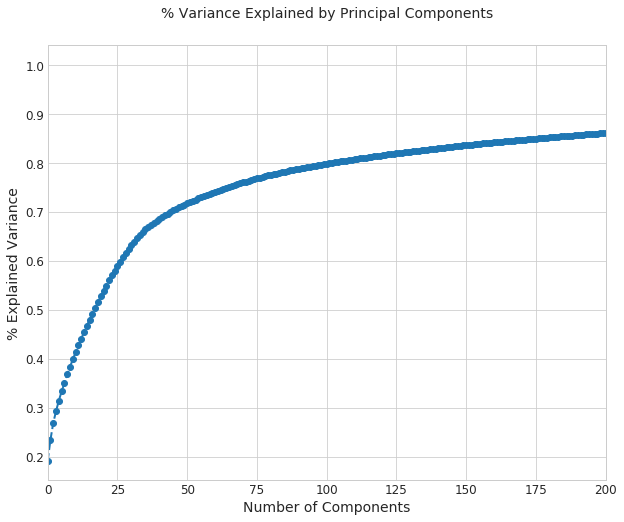

In [66]:
sns.set_style('whitegrid')
pca = PCA(random_state=0)
pca.fit(scaled_X)
plt.figure(1, figsize=(10, 8))
plt.plot(np.cumsum(pca.explained_variance_ratio_),'--o', linewidth=2)
plt.axis('tight')
plt.xlabel('Number of Components',size=14)
plt.xticks(size=12)
plt.xlim([0,200])
plt.ylabel('% Explained Variance',size=14)
plt.yticks(size=12)
plt.title('% Variance Explained by Principal Components',size=14,y=1.05)
plt.show()

In [68]:
pca=PCA(n_components=102,whiten=True,random_state=0)
X_pca_21=pca.fit_transform(scaled_X)
print("Variance explained using 152 components is:",sum(pca.explained_variance_ratio_))

Variance explained using 152 components is: 0.799317063834


In [69]:
X_train=X_pca_21[:37417]
Y_train=fs.iloc[:37417]['Target'].values
X_test=X_pca_21[37417:]
Y_test=fs.iloc[37417:]['Target'].values

## Table to store training and test measures so we can compare later
table_80_70_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_70_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])

In [70]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](X_train,Y_train,X_test,Y_test,np.arange(0,102).astype(str))
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_70_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_70_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.94954165219
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31855    37    31892
True        1851  3674     5525
__all__    33706  3711    37417

Accuracy of the model for test data is: 0.94130853111
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7971    14     7985
True         535   834     1369
__all__     8506   848     9354



Logistic Regression
Accuracy of the model for training data is: 0.955635139108
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31488   404    31892
True        1256  4269     5525
__all__    32744  4673    37417

Accuracy of the model for test data is: 0.955206328843
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7875   110     7985
True         309  1060     1369
__all__     8184  1170     9354



RandomForest Classifier
Accuracy of the model for training data is: 0.993692706524
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31885     7    31892
True         229  5296     5525
__all__    32114  5303    37417

Accuracy of the model for test data is: 0.944943339748
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7898    87     7985
True         428   941     1369
__all__     8326  1028     9354



Adaoost Classifier
Accuracy of the model for training data is: 0.944089584948
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31309   583    31892
True        1509  4016     5525
__all__    32818  4599    37417

Accuracy of the model for test data is: 0.94398118452
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7839   146     7985
True         378   991     1369
__all__     8217  1137     9354



GradientBoosting Classifier
Accuracy of the model for training data is: 0.956062752225
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31599   293    31892
True        1351  4174     5525
__all__    32950  4467    37417

Accuracy of the model for test data is: 0.952212957024
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7887    98     7985
True         349  1020     1369
__all__     8236  1118     9354



ExtraTree Classifier
Accuracy of the model for training data is: 0.99997327418
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31892     0    31892
True           1  5524     5525
__all__    31893  5524    37417

Accuracy of the model for test data is: 0.936070130425
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7917    68     7985
True         530   839     1369
__all__     8447   907     9354



Bagging Classifier
Accuracy of the model for training data is: 0.993211641767
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31884     8    31892
True         246  5279     5525
__all__    32130  5287    37417

Accuracy of the model for test data is: 0.947722899294
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7875   110     7985
True         379   990     1369
__all__     8254  1100     9354



Neural Network-1
The accuracy of the model on training data is: 0.997781756955


Predicted  False  True  __all__
Actual                         
False      31824    68    31892
True          15  5510     5525
__all__    31839  5578    37417

The accuracy of the model on test data is: 0.950074834295


Predicted  False  True  __all__
Actual                         
False       7748   237     7985
True         230  1139     1369
__all__     7978  1376     9354

### <a id='5.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [71]:
trace0 = go.Scatter(x=table_80_70_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_70_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_70_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_70_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_70_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_70_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_70_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_70_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [72]:
table_80_70_train['index']=ind_columns
table_80_70_test['index']=ind_columns


table_80_70_test.set_index(['index'],drop=True,inplace=True)
table_80_70_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_70_train)
print("Test Results")
display(table_80_70_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.949542,3674.0,31855.0,37.0,1851.0,0.001160,0.335023
LogisticRegression,0.955635,4269.0,31488.0,404.0,1256.0,0.012668,0.227330
RandomForestClassifier,0.993693,5296.0,31885.0,7.0,229.0,0.000219,0.041448
AdaBoostClassifier,0.944090,4016.0,31309.0,583.0,1509.0,0.018280,0.273122
GradientBoostingClassifier,0.956063,4174.0,31599.0,293.0,1351.0,0.009187,0.244525
ExtraTreeClassifier,0.999973,5524.0,31892.0,0.0,1.0,0.000000,0.000181
BaggingClassifier,0.993212,5279.0,31884.0,8.0,246.0,0.000251,0.044525
Neural Network-1,0.997782,5510.0,31824.0,68.0,15.0,0.002132,0.002715


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.941309,834.0,7971.0,14.0,535.0,0.001753,0.390796,0.803725,0.747807
LogisticRegression,0.955206,1060.0,7875.0,110.0,309.0,0.013776,0.225712,0.880256,0.812586
RandomForestClassifier,0.944943,941.0,7898.0,87.0,428.0,0.010895,0.312637,0.838234,0.764489
AdaBoostClassifier,0.943981,991.0,7839.0,146.0,378.0,0.018284,0.276114,0.852801,0.763241
GradientBoostingClassifier,0.952213,1020.0,7887.0,98.0,349.0,0.012273,0.254931,0.866398,0.798442
ExtraTreeClassifier,0.936070,839.0,7917.0,68.0,530.0,0.008516,0.387144,0.802170,0.721881
BaggingClassifier,0.947723,990.0,7875.0,110.0,379.0,0.013776,0.276844,0.854690,0.778376
Neural Network-1,0.950075,1139.0,7748.0,237.0,230.0,0.029681,0.168006,0.854690,0.800621


In [73]:
### Original Creator : Darshan Bhansali
### HTML code to hide the input cells 
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To toggle code, click <a href="javascript:code_toggle()">here</a>.''')